<div class="title">Spark Ecosystem &ndash; MLlib: Case Study</div>
<div class="subtitle">Máster en Big Data y Data Science</div>
<div class="author">Profesor: Carlos María Alaíz Gudín &mdash; Universidad Autónoma de Madrid</div>

---

**Configuration**

This cell defines the general configuration of Jupyter Notebook.

In [ ]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

This cell imports the packages to be used.

In [ ]:
# Standard packages.
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pyspark
from pyspark import ml

# Initialisations.
if not (("sc" in globals()) or ("sc" in locals())): sc = pyspark.SparkContext()
matplotlib.rc("figure", figsize=(15, 5))
seed = 123
spark = pyspark.sql.SparkSession(sc)

24/01/28 03:01:13 WARN Utils: Your hostname, onur-ideacenter resolves to a loopback address: 127.0.1.1; using 192.168.0.19 instead (on interface wlo1)
24/01/28 03:01:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/28 03:01:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# MLlib Case Study

## Introduction

The objective of this assignment is to address all the ML stages when tackling a classification problem, including the exploratory data analysis and the application of a ML model.

The notebook is structured in several exercises specifying the different tasks.

## Case Study using MLlib

### Dataset

The problem selected is [Adult](http://archive.ics.uci.edu/ml/datasets/Adult), available at UCI repository, composed by registers corresponding to different people and where the goal is to predict if the salary of each person will be above or below $50.000$\$ per year.

This cell loads the dataset, showing the structure and the total number of samples.

In [ ]:
adult = (
    spark.read.option("header", "true")
    .option("inferschema", "true")
    .option("mode", "DROPMALFORMED")
    .csv("./data/adult.csv")
    .cache()
)

adult.printSchema()

print("Number of samples: {}".format(adult.count()))

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- target: integer (nullable = true)

Number of samples: 32561


# Question 1

Once the dataset is loaded, a preliminary inspection can be done.

<div class="qst">

* Get the number of samples for each one of the categories corresponding to the column `"workclass"`.

<div class="notes">

* The grouping method `groupBy()` can be used.

</div>
</div>

Antes de continuar, analicemos los datos para ver cómo se distribuyen.

In [ ]:
# See the first 5 rows.
print("First 5 rows:")
adult.show(5)

# Get information about the data.
print("Summary statistics:")
adult.summary().show()

First 5 rows:
+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
|age|       workclass|fnlwgt|education|education_num|    marital_status|       occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|target|
+---+----------------+------+---------+-------------+------------------+-----------------+-------------+-----+------+------------+------------+--------------+--------------+------+
| 39|       State-gov| 77516|Bachelors|           13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|        2174|           0|            40| United-States|     1|
| 50|Self-emp-not-inc| 83311|Bachelors|           13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|           0|           0|            13| United-States|     1|
| 38|         Private|215646|  HS-grad|            9|          Divorced|Handlers-

24/01/28 03:01:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------+------------------+------------+-----------------+--------------+----------------+------------+------------------+------+------------------+----------------+------------------+--------------+-------------------+
|summary|               age|  workclass|            fnlwgt|   education|    education_num|marital_status|      occupation|relationship|              race|   sex|      capital_gain|    capital_loss|    hours_per_week|native_country|             target|
+-------+------------------+-----------+------------------+------------+-----------------+--------------+----------------+------------+------------------+------+------------------+----------------+------------------+--------------+-------------------+
|  count|             32561|      30725|             32561|       32561|            32561|         32561|           30718|       32561|             32561| 32561|             32561|           32561|             32561|         31978|             

A continuación, obtendremos el número de muestras para cada una de las categorías de la columna "workclass".

In [ ]:
################################################################################
# Insert code.
# Get the number of samples for each one of the categories of the "workclass" column.
# Hint: use the groupBy and count methods.

print("Number of samples for each category of the 'workclass' column:")
adult.groupBy("workclass").count().show()

################################################################################

Number of samples for each category of the 'workclass' column:
+----------------+-----+
|       workclass|count|
+----------------+-----+
|Self-emp-not-inc| 2541|
|            null| 1836|
|       Local-gov| 2093|
|       State-gov| 1298|
|         Private|22696|
|     Without-pay|   14|
|     Federal-gov|  960|
|    Never-worked|    7|
|    Self-emp-inc| 1116|
+----------------+-----+



---

A small summary of some features (in this case, the first $5$ ones) can be obtained through the methods `describe()` o `summary()`, although they only work with numeric columns.

In [ ]:
print("Description:")
adult.select(adult.columns[:5]).describe().show()

print("Summary:")
adult.select(adult.columns[:5]).summary().show()

Description:
+-------+------------------+-----------+------------------+------------+-----------------+
|summary|               age|  workclass|            fnlwgt|   education|    education_num|
+-------+------------------+-----------+------------------+------------+-----------------+
|  count|             32561|      30725|             32561|       32561|            32561|
|   mean| 38.58164675532078|       null|189778.36651208502|        null| 10.0806793403151|
| stddev|13.640432553581356|       null|105549.97769702227|        null|2.572720332067397|
|    min|                17|Federal-gov|             12285|        10th|                1|
|    max|                90|Without-pay|           1484705|Some-college|               16|
+-------+------------------+-----------+------------------+------------+-----------------+

Summary:
+-------+------------------+-----------+------------------+------------+-----------------+
|summary|               age|  workclass|            fnlwgt|   educa

# Question 2

A first step is to clean the data.
In particular, constant features will not have any predictive information, so they can be discarded.
Moreover, the issue of missing values should be addressed, and the easiest approach is to just remove the columns with some empty entry (with value `null`).

<div class="qst">

* Identify the number of different values of each column.
* Identify the number of missing values of each column.
* Remove the constant columns and those with missing values.

</div>

Contamos el número de valores diferentes de cada columna.

In [ ]:
################################################################################
# Insert code.
# Identify the number of different values of each column.

print("Number of different values of each column:")
for col in adult.columns:
    count_of_differentvalues = adult.select(col).distinct().count()
    print("{:<55}: {}".format("Number of different values in '{}' column".format(col), count_of_differentvalues))

################################################################################

Number of different values of each column:
Number of different values in 'age' column             : 73
Number of different values in 'workclass' column       : 9
Number of different values in 'fnlwgt' column          : 21648
Number of different values in 'education' column       : 16
Number of different values in 'education_num' column   : 16
Number of different values in 'marital_status' column  : 7
Number of different values in 'occupation' column      : 15
Number of different values in 'relationship' column    : 6
Number of different values in 'race' column            : 5
Number of different values in 'sex' column             : 2
Number of different values in 'capital_gain' column    : 119
Number of different values in 'capital_loss' column    : 92
Number of different values in 'hours_per_week' column  : 94
Number of different values in 'native_country' column  : 42
Number of different values in 'target' column          : 2


Contamos el número de valores perdidos en cada columna.

In [ ]:
# Identify the number of missing values in each column.

print("Number of missing values in each column:")
print()
for col in adult.columns:
    count_of_missingvalues = adult.filter(adult[col].isNull()).count()
    print("{:<55}: {}".format("Number of missing values in '{}' column".format(col), count_of_missingvalues))

Number of missing values in each column:

Number of missing values in 'age' column               : 0
Number of missing values in 'workclass' column         : 1836
Number of missing values in 'fnlwgt' column            : 0
Number of missing values in 'education' column         : 0
Number of missing values in 'education_num' column     : 0
Number of missing values in 'marital_status' column    : 0
Number of missing values in 'occupation' column        : 1843
Number of missing values in 'relationship' column      : 0
Number of missing values in 'race' column              : 0
Number of missing values in 'sex' column               : 0
Number of missing values in 'capital_gain' column      : 0
Number of missing values in 'capital_loss' column      : 0
Number of missing values in 'hours_per_week' column    : 0
Number of missing values in 'native_country' column    : 583
Number of missing values in 'target' column            : 0


En este caso, no eliminaremos ninguna columna, ya que no hay ninguna columna con un único valor constante. Sin embargo, podemos eliminar los valores que faltan.

In [ ]:
# Remove the missing values.
adult = adult.na.drop()

# Check if there are missing values again.
print("Number of missing values in each column:")
print()
for col in adult.columns:
    count_of_missingvalues = adult.filter(adult[col].isNull()).count()
    print("{:<55}: {}".format("Number of missing values in '{}' column".format(col), count_of_missingvalues))


Number of missing values in each column:

Number of missing values in 'age' column               : 0
Number of missing values in 'workclass' column         : 0
Number of missing values in 'fnlwgt' column            : 0
Number of missing values in 'education' column         : 0
Number of missing values in 'education_num' column     : 0
Number of missing values in 'marital_status' column    : 0
Number of missing values in 'occupation' column        : 0
Number of missing values in 'relationship' column      : 0
Number of missing values in 'race' column              : 0
Number of missing values in 'sex' column               : 0
Number of missing values in 'capital_gain' column      : 0
Number of missing values in 'capital_loss' column      : 0
Number of missing values in 'hours_per_week' column    : 0
Number of missing values in 'native_country' column    : 0
Number of missing values in 'target' column            : 0


---

To make the problem affordable, the dataset is reduced by selecting only people with an age smaller than $35$.
Moreover, the label column is renamed to follow MLlib standard.

In [ ]:
print("Number of samples (old): {:}".format(adult.count()))
adult = adult.filter(adult.age < 35).withColumnRenamed("target", "label")
print("Number of samples (new): {:}".format(adult.count()))

Number of samples (old): 30162
Number of samples (new): 12910


In [ ]:
# See the first 5 rows.
adult.show(5)

+---+---------+------+----------+-------------+------------------+--------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
|age|workclass|fnlwgt| education|education_num|    marital_status|    occupation| relationship|              race|   sex|capital_gain|capital_loss|hours_per_week|native_country|label|
+---+---------+------+----------+-------------+------------------+--------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
| 28|  Private|338409| Bachelors|           13|Married-civ-spouse|Prof-specialty|         Wife|             Black|Female|           0|           0|            40|          Cuba|    1|
| 31|  Private| 45781|   Masters|           14|     Never-married|Prof-specialty|Not-in-family|             White|Female|       14084|           0|            50| United-States|    0|
| 30|State-gov|141297| Bachelors|           13|Married-civ-spouse|Prof-specialty

# Question 3

### Data Analysis

#### Age Histogram

<div class="qst">

* Create a histogram of the column `"age"`.

<div class="notes">

  * The histogram should be computed using the RDD, so that the computationally costly part is done from Spark.
    This can be done with the method `histogram()`.
  * The figure can be plotted locally using `pyplot` and the computed frequencies.

</div>
</div>

Para calcular la distribución de las edades, usaremos RDD para la columna 'age' de nuestro conjunto de datos. Luego, usaremos PyPlot para crear un gráfico de histogram que represente los datos.

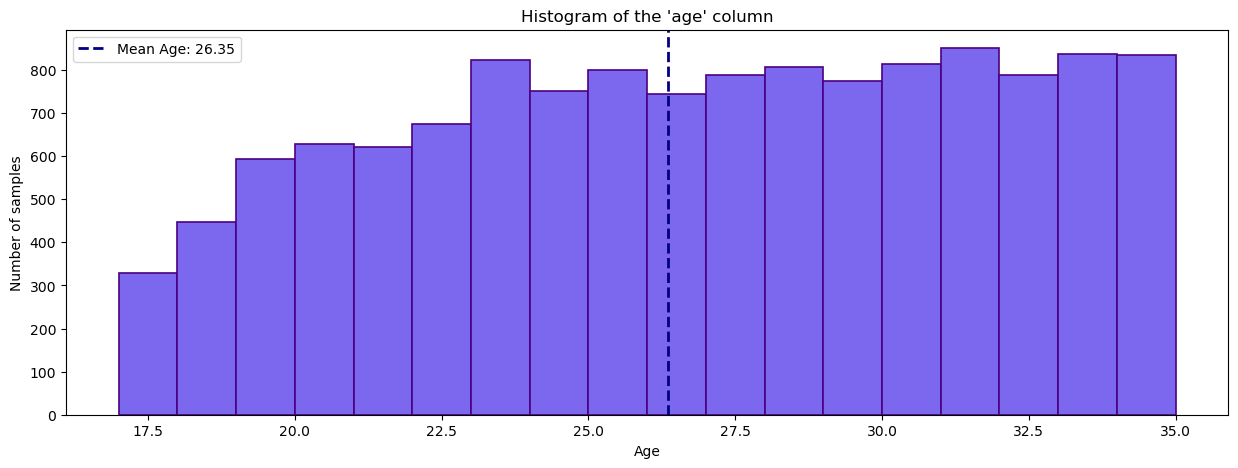

In [ ]:
# Bins for the histogram.
bins = np.linspace(17, 35, 19).tolist()

################################################################################
# Insert code.
# Plot the histogram of the "age" column using RDD.
# Write a header for the plot.
age_rdd = adult.select("age").rdd.flatMap(lambda x: x)
mean_age = age_rdd.mean()
plt.hist(age_rdd.collect(), bins=bins, color="mediumslateblue", edgecolor="indigo", linewidth=1.2)
plt.axvline(mean_age, color='navy', linestyle='dashed', linewidth=2, label='Mean Age: {:.2f}'.format(mean_age))
plt.title("Histogram of the 'age' column")
plt.xlabel("Age")
plt.ylabel("Number of samples")
plt.legend()
plt.show()


################################################################################

---

# Question 4

#### Distribution by Marital Status

<div class="qst">

* Compute the percentage of samples for each value of the column `"marital_status"`.
* Represent the previous distribution using a pie chart.

<div class="notes">

  * The percentages should be computed using Spark.
  * The figure can be plotted locally using `pyplot` and the computed percentages.

</div>
</div>

Para visualizar la distribución de marital_status, agruparemos la columna 'marital_status' por categoría. Luego, contaremos el número de observaciones en cada categoría y calcularemos el porcentaje. Finalmente, crearemos un gráfico de pastel que muestre los resultados.

+--------------------+-----+-------------------+
|      marital_status|count|         percentage|
+--------------------+-----+-------------------+
|           Separated|  330| 2.5561580170410534|
|       Never-married| 7687|   59.5429899302866|
|Married-spouse-ab...|  134| 1.0379550735863672|
|            Divorced|  916|  7.095274980635166|
|             Widowed|   25|0.19364833462432224|
|   Married-AF-spouse|   15|0.11618900077459333|
|  Married-civ-spouse| 3803|   29.4577846630519|
+--------------------+-----+-------------------+



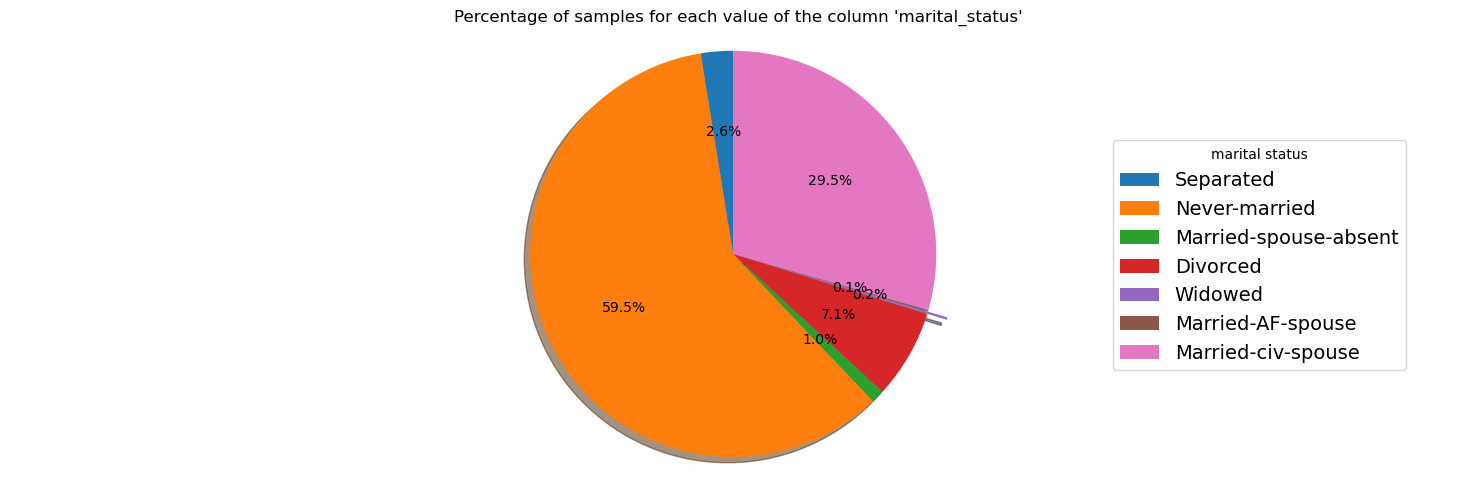

In [ ]:
################################################################################
# Insert code.
# Compute the percentage of samples for each value of the column "marital_status" by using spark and plot a pie chart.

maritalstatus = adult.groupBy("marital_status").count()
maritalstatus = maritalstatus.withColumn("percentage", maritalstatus["count"]/adult.count()*100)
maritalstatus.show()

# Plot a pie chart.
labels = maritalstatus.select("marital_status").rdd.flatMap(lambda x: x).collect()
sizes = maritalstatus.select("percentage").rdd.flatMap(lambda x: x).collect()
explode = (0, 0, 0, 0, 0.1, 0, 0)
fig1, ax1 = plt.subplots()
wedges, texts, autotexts = ax1.pie(sizes, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of samples for each value of the column 'marital_status'")

ax1.legend(wedges, labels,
          title="marital status",
          loc="center left",
          bbox_to_anchor=(0.75, 0, 0.5, 1),
          fontsize=14)


# Apply equal aspect ratio.
plt.tight_layout()
plt.show()



################################################################################

---

# Question 5

### Data Preprocessing

Data preprocessing can be critical for the correct performance of ML models.
The first step is to split the dataset into training and test partitions.

<div class="qst">

* Split randomly the dataset into a training partition with $70\%$ of the data (`adult_tr`) and a test partition with $30\%$ of the data (`adult_te`), using the random seed `seed`.

</div>

Para preparar los datos para el entrenamiento, dividiremos el conjunto de datos original en dos partes: un conjunto de entrenamiento ('adult_tr') y un conjunto de prueba ('adult_te').

In [ ]:
################################################################################
# Insert code.
# Split randomly the dataset into training partition with 70% of the data (adult_tr) and a test partition with 30% of the data (adult_te) by using random seed seed.
seed = 42
adult_tr, adult_te = adult.randomSplit([0.7, 0.3], seed=seed)
print("Number of samples in the training partition: {}".format(adult_tr.count()))
print("Number of samples in the test partition: {}".format(adult_te.count()))
print()
print("adult_tr:")
adult_tr.show(10)
print()
print("adult_te:")
adult_te.show(10)


################################################################################

Number of samples in the training partition: 9142
Number of samples in the test partition: 3768

adult_tr:
+---+-----------+------+---------+-------------+--------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+-----+
|age|  workclass|fnlwgt|education|education_num|marital_status|     occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|label|
+---+-----------+------+---------+-------------+--------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+-----+
| 17|Federal-gov| 99893|     11th|            7| Never-married|   Adm-clerical|Not-in-family|Black|Female|           0|        1602|            40| United-States|    1|
| 17|  Local-gov| 32124|      9th|            5| Never-married|  Other-service|    Own-child|Black|  Male|           0|           0|             9| United-States|    1|
| 17|  Local-gov|148194|     11th|            7|

---

In order to properly preprocess each column, it is important to identify if it corresponds to a categorical feature or to a numerical one.
This is done in the cell below, assuming that the categorical features are the columns of type `"string"`, and the remaining ones are numerical features (except for the label).

In [ ]:
features_cat = []
features_num = []
for feature, field_type in adult_tr.dtypes:
    if field_type == "string":
        features_cat.append(feature)
    else:
        features_num.append(feature)
features_num.remove("label")

print("Categorical features:", features_cat)
print("Numerical features:  ", features_num)

Categorical features: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
Numerical features:   ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


# Question 6

#### StringIndexers

The first step to deal with categorical features is to transform them into numerical features, using a series of StringIndexers, which will be later combined in a single Pipeline.

<div class="qst">

* Create a list of StringIndexers named `indexers`, each of which will transform one of the categorical features and will create a new numerical feature whose name will be the original one with the suffix `"_ind"`.
* Create a Pipeline that combines all the StringIndexers to check over the DataFrame `adult_tr` that the transformation is the desired one.

</div>

Para convertir las características categóricas a numéricas, crearemos una lista de StringIndexers. Cada StringIndexer transformará una característica y creará una nueva característica numérica con el nombre original y el sufijo "_ind".

Luego, crearemos un Pipeline que combine todos los StringIndexers y lo aplicaremos al DataFrame 'adult_tr' y 'adult_te' para comprobar que la transformación es correcta.

In [ ]:
################################################################################
# Insert code.

# Create a list of StringIndexer named indexers that will be used to transform the categorical features into numerical ones.

indexers = [ml.feature.StringIndexer(inputCol=column, outputCol=column+"_ind").fit(adult_tr) for column in features_cat]

# Create a Pipeline that combines all the StringIndexers.
pipeline = ml.Pipeline(stages=indexers)
transformed_adult_tr = pipeline.fit(adult_tr).transform(adult_tr)
transformed_adult_te = pipeline.fit(adult_te).transform(adult_te)

# See the first 20 rows.
transformed_adult_tr.show(10)



################################################################################

+---+-----------+------+---------+-------------+--------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+-----+-------------+-------------+------------------+--------------+----------------+--------+-------+------------------+
|age|  workclass|fnlwgt|education|education_num|marital_status|     occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|label|workclass_ind|education_ind|marital_status_ind|occupation_ind|relationship_ind|race_ind|sex_ind|native_country_ind|
+---+-----------+------+---------+-------------+--------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+-----+-------------+-------------+------------------+--------------+----------------+--------+-------+------------------+
| 17|Federal-gov| 99893|     11th|            7| Never-married|   Adm-clerical|Not-in-family|Black|Female|           0|        1602|            40| 

---

# Question 7

#### OneHotEncoders

The next step is to transform the numerical categorical features into binary features, using OneHotEncoders, which will be later added to the final Pipeline.

<div class="qst">

* Create a list of OneHotEncoders named `encoders`, each of which will transform one of the output features of the StringIndexers to a binary vector, whose name will be the original one with the suffix `"_ind_oh"`.
* Create a Pipeline that combines all the transformations (both the `indexers` and the `encoders`) to check over the DataFrame `adult_tr` that the transformation is the desired one.

</div>

Para convertir las características categóricas a vectores binarios, usamos OneHotEncoder y las nuevas columnas terminan con _ind_oh.

Luego, crearemos un Pipeline que combine todos los OneHotEncoder y lo aplicaremos al DataFrame 'adult_tr' y 'adult_te' para comprobar que la transformación es correcta.

In [ ]:
################################################################################
# Insert code.

# See name of the indexed columns.
indexed_columns = []

for column in transformed_adult_tr.columns:
    if "_ind" in column:
        indexed_columns.append(column)

print("indexed_columns:", indexed_columns)
print()

# Create a list of OneHotEncoder named encoders that tranforms one of the output columns of the StringIndexer into a binary vector.
encoders = [ml.feature.OneHotEncoder(inputCol=column, outputCol=column+"_oh") for column in indexed_columns]

# Create a Pipeline that combines all the transformations (indexers and encoders).
pipeline = ml.Pipeline(stages=indexers + encoders)
transformed_adult_tr = pipeline.fit(adult_tr).transform(adult_tr)
transformed_adult_te = pipeline.fit(adult_te).transform(adult_te)


# See the first 20 rows.
transformed_adult_tr.show(10)



################################################################################

indexed_columns: ['workclass_ind', 'education_ind', 'marital_status_ind', 'occupation_ind', 'relationship_ind', 'race_ind', 'sex_ind', 'native_country_ind']

+---+-----------+------+---------+-------------+--------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+-----+-------------+-------------+------------------+--------------+----------------+--------+-------+------------------+----------------+----------------+---------------------+-----------------+-------------------+-------------+-------------+---------------------+
|age|  workclass|fnlwgt|education|education_num|marital_status|     occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|label|workclass_ind|education_ind|marital_status_ind|occupation_ind|relationship_ind|race_ind|sex_ind|native_country_ind|workclass_ind_oh|education_ind_oh|marital_status_ind_oh|occupation_ind_oh|relationship_ind_oh|  race_ind_oh|   sex_ind_oh|native_co

---

# Question 8

#### Feature Concatenation

The last step is to concatenate all the features into a single column, including both the initially numerical features and the ones created using the OneHotEncoders.
This will be the last preprocessing level of the Pipeline.

<div class="qst">

* Create a VectorAssembler named `assembler` that concatenates both the initially numerical features and those create through the OneHotEncoders into a single column named `"features"`.
* Create a Pipeline that combines all the transformations (the `indexers`, the `encoders` and the `assembler`) to check over the DataFrame `adult_tr` that the transformation is the desired one.

</div>

Creamos un VectorAssembler que concatene las características numéricas y las características categóricas binarizadas en una única columna llamada features.

Luego, crearemos un Pipeline que combine todos los indexers. encodeers y assembler y lo aplicaremos al DataFrame 'adult_tr' y 'adult_te' para comprobar que la transformación es correcta.

In [ ]:
################################################################################
# Insert code.

# See name of the one-hot encoded columns.
onehotencoded_columns = []
for column in transformed_adult_tr.columns:
    if "_oh" in column:
        onehotencoded_columns.append(column)
print("onehotencoded_columns:", onehotencoded_columns)
print()

# Create a VectorAssembler named assembler that concatenates both the initially numerical features and those create by the OneHotEncoder into a single column named "features".

assembler = [ml.feature.VectorAssembler(inputCols=features_num + onehotencoded_columns, outputCol="features")]

# Create a Pipeline that combines all the transformations (indexers, encoders and assembler).
pipeline = ml.Pipeline(stages=indexers + encoders + assembler)
transformed_adult_tr = pipeline.fit(adult_tr).transform(adult_tr)
transformed_adult_te = pipeline.fit(adult_te).transform(adult_te)

# See the first 20 rows.
transformed_adult_tr.show(20)


################################################################################

onehotencoded_columns: ['workclass_ind_oh', 'education_ind_oh', 'marital_status_ind_oh', 'occupation_ind_oh', 'relationship_ind_oh', 'race_ind_oh', 'sex_ind_oh', 'native_country_ind_oh']

+---+-----------+------+---------+-------------+--------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+-------------+-------------+------------------+--------------+----------------+--------+-------+------------------+----------------+----------------+---------------------+-----------------+-------------------+-------------+-------------+---------------------+--------------------+
|age|  workclass|fnlwgt|education|education_num|marital_status|       occupation| relationship|              race|   sex|capital_gain|capital_loss|hours_per_week|native_country|label|workclass_ind|education_ind|marital_status_ind|occupation_ind|relationship_ind|race_ind|sex_ind|native_country_ind|workclass_ind_oh|education_ind_oh|marital_status_i

---

### Logistic Regression

It is important to notice that the problem is unbalanced, as shown next.

In [ ]:
transformed_adult_tr.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 8127|
|    0| 1015|
+-----+-----+



# Question 9

A simple logistic regression model will be used as the classifier.

<div class="qst">

* Create a logistic regression Estimator with a regularization parameter of $100$, named `logreg_es`.
* Create a Pipeline, named `pipeline_es`, with all the stages combined (`indexers`, `encoders`, `assembler` and `logreg_es`).
* Train the Estimator `pipeline_es` using the DataFrame `adult_tr`, and save the resultant Transformer in a variable `pipeline_tr`.

</div>

Creamos un estimador de regresión logística llamado logreg_es con un parámetro de regularización de 100.

Luego, creamos un Pipeline llamado pipeline_es que combina todas las etapas del proceso de transformación.

Finalmente, entrenamos el estimador logreg_es usando el DataFrame transformado transformed_adult_tr. Guardamos el transformador resultante en una variable llamada pipeline_tr

In [ ]:
################################################################################
# Insert code.
# Create a logistic regression Estimator named logred_es with a regularization parameter of 100

logreg_es = [ml.classification.LogisticRegression(regParam=100, featuresCol='features', labelCol='label')]

# Create a Pipeline named pipeline_es by combining all the stages (indexers, encoders, assembler and logred_es).
pipeline_es = ml.Pipeline(stages=logreg_es)

# Train the Estimator pipeline_es by using transformed_adul_tr and save the resultant Transformer in a variable named pipeline_tr.
pipeline_tr = pipeline_es.fit(transformed_adult_tr)

print(pipeline_tr)

transformed_adult_tr.show(5)

# pipeline_tr.transform(adult_te).show(5)

################################################################################

PipelineModel_c3b0e0d26b34
+---+-----------+------+---------+-------------+--------------+---------------+-------------+-----+------+------------+------------+--------------+--------------+-----+-------------+-------------+------------------+--------------+----------------+--------+-------+------------------+----------------+----------------+---------------------+-----------------+-------------------+-------------+-------------+---------------------+--------------------+
|age|  workclass|fnlwgt|education|education_num|marital_status|     occupation| relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|label|workclass_ind|education_ind|marital_status_ind|occupation_ind|relationship_ind|race_ind|sex_ind|native_country_ind|workclass_ind_oh|education_ind_oh|marital_status_ind_oh|occupation_ind_oh|relationship_ind_oh|  race_ind_oh|   sex_ind_oh|native_country_ind_oh|            features|
+---+-----------+------+---------+-------------+--------------+------------

---

# Question 10

It is important to evaluate the model, checking its performance in both the training and the test partitions.
Since the problem is unbalanced, the AUC metrics will be more appropriate than the accuracy.

<div class="qst">

* Complete the function `printMetrics()`, which receives a DataFrame with predictions and prints both the area under the ROC curve and the area under the PR curve.
* Use the function `printMetrics()` to evaluate the previous ML model over the training and test partitions.

</div>

Completamos la función printMetrics(), que recibe un DataFrame con predicciones y muestra tanto el área bajo la curva ROC como el área bajo la curva PR utilizando la métrica AUC.

Utilizamos la función printMetrics() para evaluar el modelo de ML anterior sobre las particiones de entrenamiento y prueba.

In [ ]:
# Function.
def printMetrics(df_te, pipe_tr):
    """Prints the AUC metrics for the predictions contained in the DataFrame df.

    Args:
        df (DataFrame): DataFrame with the binary classification predictions.
    """
    ############################################################################
    # Insert code.
    # Create a BinaryClassificationEvaluator named evaluator.
    evaluator = ml.evaluation.BinaryClassificationEvaluator()
    # Get a DataFrame with the predictions and prints the area under the ROC curve and area under the PR curve.
    predictions = pipe_tr.transform(df_te)
    print("AUC ROC: {:5.2f}%".format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}) * 100))
    print("AUC PR:  {:5.2f}%".format(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}) * 100))


printMetrics(transformed_adult_te, pipeline_tr)



    ############################################################################


# Performance.
################################################################################
# Insert code.

################################################################################

AUC ROC: 90.95%
AUC PR:  98.62%


---

# Question 11

### Hyper-Parameter Tuning

<div class="qst">

* Tune the `regParam` hyper-parameter of the logistic regression model using cross-validation with $3$ folds and the default metric of the evaluator, trying the values $(10^{-3}, 10^{-2}, 10^{-1}, 10^{0}, 10^{1}, 10^{2}, 10^{3})$.
  Use the DataFrame `adult_tr`, and save the resultant Transformer in the variable `cv_tr`.
* Use the function `printMetrics()` to evaluate the tuned ML model over the training and test partitions, comparing the results with those of the previous model.

</div>

In [ ]:
################################################################################
# Insert code.

# Arrange the regParam hyperparameter of the LogisticRegression model by using cross-validation with 3 foldsand the default metric of evaluator and by triying the values 0.001, 0.01, 0.1, 1, 10, 100, 1000.
# Use dataframes adult_tr and save the resultant Transformer in a variable named cv_tr.

logreg_es2 = ml.classification.LogisticRegression()
pipeline_es2 = ml.Pipeline(stages=[logreg_es2])


paramGrid = ml.tuning.ParamGridBuilder().addGrid(logreg_es2.regParam, [0.001, 0.01, 0.1, 1, 10, 100, 1000]).build()

evaluator = ml.evaluation.BinaryClassificationEvaluator()
cv = ml.tuning.CrossValidator(estimator=pipeline_es2, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, seed=1234)
cv_tr = cv.fit(transformed_adult_tr)
print(cv_tr)

# print("Metrics for Tuned Model:")
printMetrics(transformed_adult_te, cv_tr.bestModel)

# Get the best hyper-parameters
output_str = str(cv_tr.bestModel.stages[-1].extractParamMap())
search_str = "name='regParam', doc='regularization parameter (>= 0).'):"
ind_1 = output_str.find(search_str) + len(search_str)
ind_2 = output_str[ind_1:].find(",") + ind_1
best_param = float(output_str[ind_1:ind_2])

print("Best Hyper-parameters: {}".format(best_param))


################################################################################

CrossValidatorModel_02d5579c61c1
AUC ROC: 92.26%
AUC PR:  98.69%
Best Hyper-parameters: 0.01


AUC ROC (Area Under the Receiver Operating Characteristic Curve):
* Con regParam = 0,01: AUC ROC = 92,26%.
* Con regParam = 100: AUC ROC = 90,95%.

El AUC ROC mide la capacidad del modelo para distinguir entre las clases positiva y negativa. Un AUC ROC más alto indica un mejor rendimiento. En este caso, el modelo con regParam = 0,01 alcanzó un AUC ROC más alto, lo que indica que tiene mejor capacidad de discriminación para separar las muestras positivas y negativas en comparación con el modelo con regParam = 100.

AUC PR (Area Under the Precision-Recall Curve):
* Con regParam = 0,01: AUC PR = 98,69%.
* Con regParam = 100: AUC PR = 98,62%.

El AUC PR mide el equilibrio entre precisión y recuperación en función de distintos umbrales. Un AUC PR más alto indica un mejor rendimiento en precisión y recuperación. En este caso, el modelo con regParam = 0,01 obtuvo un AUC PR ligeramente superior al del modelo con regParam = 100.


En este caso, el modelo con regParam = 0,01 obtuvo mejores resultados que el modelo con regParam = 100 en términos de AUC ROC y AUC PR, lo que indica que el modelo se benefició de una menor regularización y fue capaz de capturar patrones más complejos en los datos, dando como resultado un mejor rendimiento predictivo. Sin embargo, la diferencia de rendimiento entre los dos modelos es pequeña, lo que sugiere que el parámetro puede no tener un impacto significativo en el rendimiento del modelo en este escenario concreto.

---

# Question 12

### Other ML Models

<div class="qst">

* Try to improve the previous results with at least one more ML model, adjusting the main hyper-parameters.
* Use the function `printMetrics()` to evaluate the new models, comparing them with the linear one, and discuss the results.

</div>

In [ ]:
################################################################################
# Insert code.

# Adjust the main hyper-parameters and apply Decision Tree Classifier.
# Use dataframes transformed_adult_tr and save the resultant Transformer in a variable named cv_tr2.

dtc_es = ml.classification.DecisionTreeClassifier()
pipeline_es3 = ml.Pipeline(stages=[dtc_es])

# Adjust the main hyper-parameters.
paramGrid = ml.tuning.ParamGridBuilder().addGrid(dtc_es.maxDepth, [2, 5, 10]).addGrid(dtc_es.maxBins, [10, 20, 40]).build()

evaluator = ml.evaluation.BinaryClassificationEvaluator()
cv = ml.tuning.CrossValidator(estimator=pipeline_es3, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, seed=1234)
cv_tr2 = cv.fit(transformed_adult_tr)
print(cv_tr2)

# Use printMetrics function.
printMetrics(transformed_adult_te, cv_tr2.bestModel)


# Get the best hyper-parameters
output_str = str(cv_tr2.bestModel.stages[-1].extractParamMap())

search_str = "name='maxDepth', doc='Maximum depth of the tree."
ind_1 = output_str.find(search_str)
ind_2 = output_str[ind_1:].find("'):") + ind_1 + 3
ind_3 = output_str[ind_2:].find(",") + ind_2
best_param = float(output_str[ind_2:ind_3])

print("Best Hyper-parameters: {}".format(best_param))



################################################################################

CrossValidatorModel_dce0bcfd01c1
AUC ROC: 86.18%
AUC PR:  97.74%
Best Hyper-parameters: 5.0


In [ ]:
# Adjust the main hyper-parameters and apply LinearSVC.
# Use dataframes transformed_adult_tr and save the resultant Transformer in a variable named cv_tr3.

lsvc_es = ml.classification.LinearSVC()
pipeline_es4 = ml.Pipeline(stages=[lsvc_es])

# Adjust the main hyper-parameters.
paramGrid = ml.tuning.ParamGridBuilder().addGrid(lsvc_es.maxIter, [10, 100, 1000]).addGrid(lsvc_es.regParam, [0.01, 0.1, 1]).build()

evaluator = ml.evaluation.BinaryClassificationEvaluator()
cv = ml.tuning.CrossValidator(estimator=pipeline_es4, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3, seed=1234)
cv_tr3 = cv.fit(transformed_adult_tr)
print(cv_tr3)

# Use printMetrics function.
printMetrics(transformed_adult_te, cv_tr3.bestModel)

# Get the best hyper-parameters
output_str = str(cv_tr3.bestModel.stages[-1].extractParamMap())
# print(output_str)

search_str = "name='regParam', doc='regularization parameter (>= 0).'):"
ind_1 = output_str.find(search_str) + len(search_str)
ind_2 = output_str[ind_1:].find(",") + ind_1
best_param = float(output_str[ind_1:ind_2])
print("Best Hyper-parameters: {}".format(best_param))


CrossValidatorModel_4098b0599fb9
AUC ROC: 91.51%
AUC PR:  98.60%
Best Hyper-parameters: 1.0


**Logistic Regression** suele funcionar bien en tareas de clasificación binaria, especialmente cuando la relación entre las características y la variable objetivo es aproximadamente lineal en el espacio log-odds.

**LinearSVC** (Support Vector Classifier with linear kernel) es otro clasificador lineal, pero su rendimiento puede diferir del de la regresión logística debido a las diferencias en los objetivos de optimización y los límites de decisión.

**DecisionTreeClassifier** construye un árbol de decisión binario basado en divisiones de características, que puede capturar relaciones complejas pero puede llevar a un sobreajuste si no se regulariza adecuadamente.

**AUC ROC:** Logistic Regression (92.26%) > LinearSVC (91.51%) > DecisionTreeClassifier (86.18%)

**AUC PR:** Logistic Regression (98.69%) > LinearSVC (98.60%) > DecisionTreeClassifier (97.74%)

Según las métricas proporcionadas, Logistic Regression supera tanto a LinearSVC como a DecisionTreeClassifier en términos de AUC ROC y AUC PR. LinearSVC obtiene mejores resultados que DecisionTreeClassifier en ambas métricas, pero es superado por Logistic Regression.

---